In [1]:
!nvidia-smi

Tue Aug  6 11:43:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Setup

In [2]:
# install tensorflow 2.15 since voxelmorph is not compatible with current build
import tensorflow as tf
if not tf.__version__.startswith('2.15'):
  !pip uninstall -y tensorflow
  !pip install tensorflow==2.15
# install voxelmorph
!pip install voxelmorph

In [3]:
import voxelmorph as vxm
import neurite as ne

import os
import urllib.request
import zipfile
import json
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import cv2

from sklearn.model_selection import train_test_split

# Download dataset

In [4]:
# download dataset
filename = 'COMULISSHGBF.zip'
if not os.path.exists(filename):
    url = 'https://cloud.imi.uni-luebeck.de/s/QQKxdTGoLPmEbc4/download/COMULISSHGBF.zip'
    urllib.request.urlretrieve(url, filename)

    # extract files
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('./')

In [5]:
def load_data(jsonData, dataFolderPath, filterString='0001'):
    training_paths = []
    for i in range(len(jsonData['training_paired_images'])):
        tmproot, tmpext = os.path.splitext(jsonData['training_paired_images'][i]['moving'])
        root, ext = os.path.splitext(tmproot)
        splitRoot = root.split('_')
        if splitRoot[-1] == filterString:
            training_paths.append(jsonData['training_paired_images'][i])

    fixedData = []
    movingData = []
    for image in training_paths:
        fixedImg = nib.load(dataFolderPath + image['fixed'].removeprefix('.')).get_fdata()
        fixedData.append(fixedImg.astype(np.uint8))
        movingImg = nib.load(dataFolderPath + image['moving'].removeprefix('.')).get_fdata()
        movingImg_reshaped = movingImg.reshape(jsonData['tensorImageShape'][0]['0'][0], jsonData['tensorImageShape'][0]['0'][1], 3)
        movingData.append(movingImg_reshaped.astype(np.uint8))

    return np.array(fixedData), np.array(movingData)

In [6]:
# load data
with open('./COMULISSHGBF/COMULISSHGBF_dataset.json', 'r') as file:
  data_json = json.load(file)
dataFolder = './COMULISSHGBF'
data_fixed_raw, data_moved_raw = load_data(data_json, dataFolder)

(-0.5, 833.5, 833.5, -0.5)

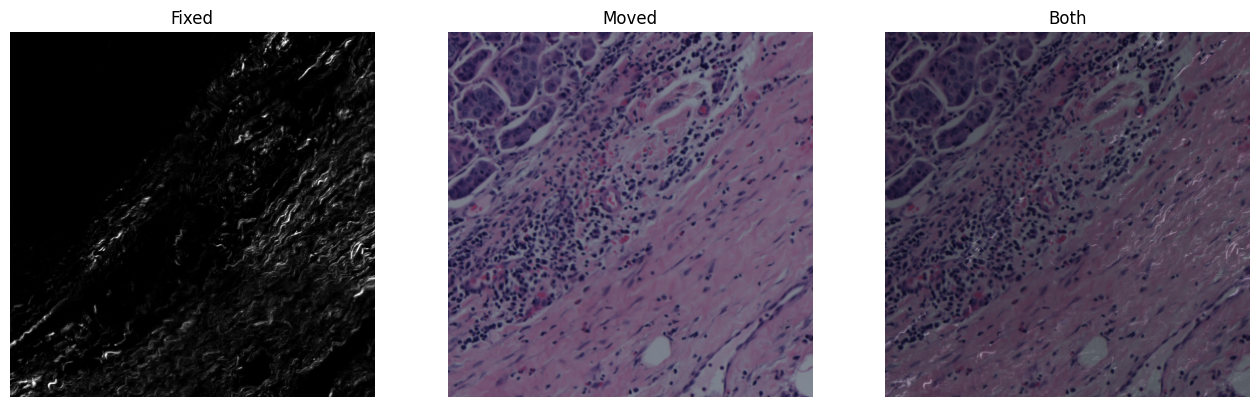

In [187]:
# preview data
img = 31

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16,8))
ax0.imshow(data_fixed_raw[img],cmap='gray')
ax0.set_title("Fixed")
ax0.axis("off")
ax1.imshow(data_moved_raw[img])
ax1.set_title("Moved")
ax1.axis("off")
ax2.imshow(data_fixed_raw[img],cmap='gray')
ax2.imshow(data_moved_raw[img], alpha=0.7)
ax2.set_title("Both")
ax2.axis("off")

# Preprocess Data

In [220]:
# filter data
means = np.mean(data_fixed_raw, axis=(1,2,3))
mask = means >= 3

data_fixed_filtered = data_fixed_raw[mask]
data_moved_filtered = data_moved_raw[mask]

In [222]:
target_size = (512, 512)

# Resize images
data_fixed_resized = []
for sample in data_fixed_filtered:
    data_fixed_resized.append(cv2.resize(sample,target_size))
data_fixed_resized = np.array(data_fixed_resized)

data_moved_resized = []
for sample in data_moved_filtered:
    data_moved_resized.append(cv2.resize(sample,target_size))
data_moved_resized = np.array(data_moved_resized)

# Get moved images as grayscales
data_moved_gray = np.zeros_like(data_fixed_resized)
for idx, val in enumerate(data_moved_resized):
    data_moved_gray[idx] = cv2.cvtColor(val, cv2.COLOR_RGB2GRAY)

# get gradient of moved images
data_moved_gradient = np.zeros_like(data_moved_gray)
for idx, val in enumerate(data_moved_gray):
    gaussian_blurred = cv2.GaussianBlur(val, (5, 5), 0)
    sobel_x = cv2.Sobel(gaussian_blurred, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gaussian_blurred, cv2.CV_64F, 0, 1, ksize=3)
    gradient = np.sqrt(sobel_x**2, sobel_y**2)
    eroded = cv2.erode(gradient, np.ones((5, 5), np.uint8), iterations=1)
    data_moved_gradient[idx] = cv2.dilate(eroded, np.ones((5, 5), np.uint8), iterations=1)

# Normalize images
data_fixed_normalized = data_fixed_resized / np.max(data_fixed_resized)
data_moved_normalized = data_moved_gradient / np.max(data_moved_gradient)

In [223]:
data_fixed_normalized.shape

(124, 512, 512)

In [224]:
data_moved_normalized.shape

(124, 512, 512)

In [230]:
def find_subarray_index(large_array, subarray):
    for i in range(large_array.shape[0]):
        if np.array_equal(large_array[i], subarray):
            return i

new_idx = find_subarray_index(data_fixed_filtered, data_fixed_raw[img])

(-0.5, 511.5, 511.5, -0.5)

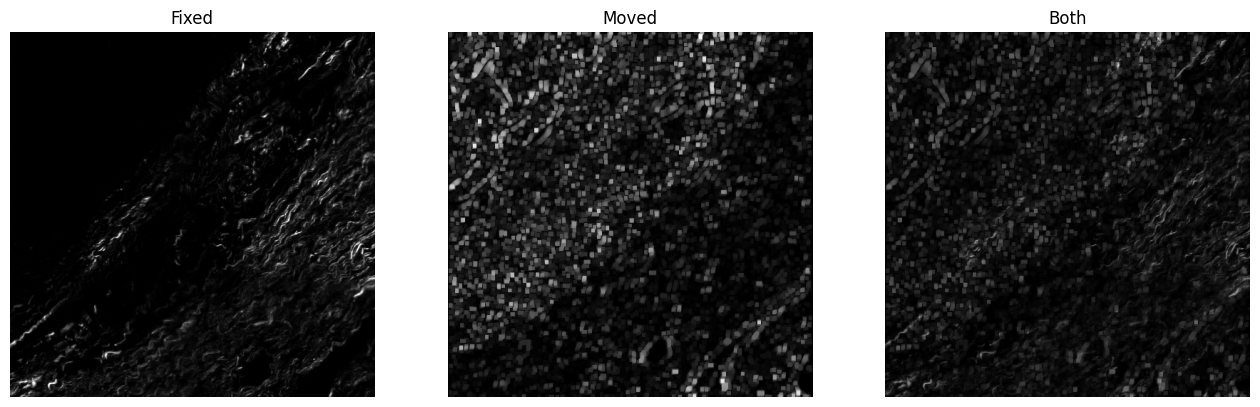

In [231]:
# view preprocessed data
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16,8))
ax0.imshow(data_fixed_normalized[new_idx],cmap='gray')
ax0.set_title("Fixed")
ax0.axis("off")
ax1.imshow(data_moved_normalized[new_idx],cmap='gray')
ax1.set_title("Moved")
ax1.axis("off")
ax2.imshow(data_fixed_normalized[new_idx],cmap='gray')
ax2.imshow(data_moved_normalized[new_idx],cmap='gray', alpha=0.5)
ax2.set_title("Both")
ax2.axis("off")

In [232]:
# split dataset
random_state = 10

fixed_train, fixed_test, moved_train, moved_test = train_test_split(data_fixed_normalized, data_moved_normalized, test_size=0.2, random_state=random_state)
fixed_val, fixed_test, moved_val, moved_test = train_test_split(fixed_test, moved_test, test_size=0.5, random_state=random_state)

In [100]:
fixed_train.shape

(132, 512, 512)

In [101]:
fixed_val.shape

(17, 512, 512)

In [102]:
fixed_test.shape

(17, 512, 512)

# Define Model

In [103]:
# Define the input shapes
inshape = data_fixed_normalized.shape[1:3]
nb_features = [
    [32, 64, 128, 256],  # encoder-channels
    [256, 128, 64, 32, 32]  # eecoder-channels
]

# build model using VxmDense
vxm_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)

print('input shape: ', ', '.join([str(t.shape) for t in vxm_model.inputs]))
print('output shape:', ', '.join([str(t.shape) for t in vxm_model.outputs]))

input shape:  (None, 512, 512, 1), (None, 512, 512, 1)
output shape: (None, 512, 512, 1), (None, 512, 512, 2)


In [104]:
# define loss functions
losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]

# balance the two losses with hyper-parameter
lambda_param = 0.05
loss_weights = [1, lambda_param]

In [105]:
# compile model
vxm_model.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights)

# Train model

In [106]:
# define a data generator that adds augmentation
def vxm_data_generator(fixed, moved, batch_size=32):
    vol_shape = fixed.shape[1:3]
    ndims = len(vol_shape)

    # prepare a zero array the size of the deformation
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])

    while True:
        idx = np.random.randint(0, fixed.shape[0], size=batch_size)

        fixed_image = fixed[idx, ..., np.newaxis]
        moving_image = moved[idx, ..., np.newaxis]

        if np.random.randint(0,2) == 0:
          fixed_image = np.flip(fixed_image,1)
          moving_image = np.flip(moving_image,1)

        for _ in range(np.random.randint(0,4)):
          fixed_image = np.rot90(fixed_image,axes=(1,2))
          moving_image = np.rot90(moving_image,axes=(1,2))

        inputs = [moving_image, fixed_image]
        outputs = [fixed_image, zero_phi]

        yield (inputs, outputs)

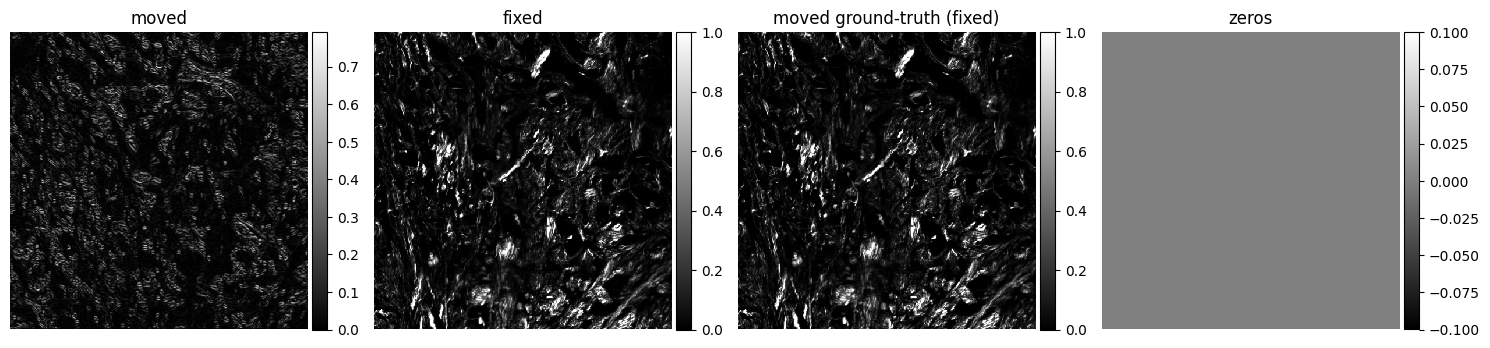

In [107]:
batch_size = 16

# define training generator
train_generator = vxm_data_generator(fixed_train, moved_train, batch_size=batch_size)
in_sample, out_sample = next(train_generator)

# view generated data
images = [img[0, :, :, 0] for img in in_sample + out_sample]
titles = ['moved', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [108]:
# define  validation generator
val_generator = vxm_data_generator(fixed_val, moved_val, batch_size=batch_size//4)

In [109]:
## include validation set??
# train model
nb_epochs = 20
steps_per_epoch = 20
validation_steps = 2
hist = vxm_model.fit(
    train_generator,
    epochs=nb_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    verbose=2
)

Epoch 1/20
20/20 - 20s - loss: 0.0251 - vxm_dense_transformer_loss: 0.0250 - vxm_dense_flow_loss: 0.0030 - val_loss: 0.0205 - val_vxm_dense_transformer_loss: 0.0200 - val_vxm_dense_flow_loss: 0.0095 - 20s/epoch - 995ms/step
Epoch 2/20
20/20 - 13s - loss: 0.0250 - vxm_dense_transformer_loss: 0.0243 - vxm_dense_flow_loss: 0.0138 - val_loss: 0.0215 - val_vxm_dense_transformer_loss: 0.0206 - val_vxm_dense_flow_loss: 0.0169 - 13s/epoch - 670ms/step
Epoch 3/20
20/20 - 14s - loss: 0.0239 - vxm_dense_transformer_loss: 0.0230 - vxm_dense_flow_loss: 0.0169 - val_loss: 0.0172 - val_vxm_dense_transformer_loss: 0.0165 - val_vxm_dense_flow_loss: 0.0141 - 14s/epoch - 689ms/step
Epoch 4/20
20/20 - 14s - loss: 0.0268 - vxm_dense_transformer_loss: 0.0259 - vxm_dense_flow_loss: 0.0194 - val_loss: 0.0216 - val_vxm_dense_transformer_loss: 0.0208 - val_vxm_dense_flow_loss: 0.0165 - 14s/epoch - 683ms/step
Epoch 5/20
20/20 - 13s - loss: 0.0217 - vxm_dense_transformer_loss: 0.0207 - vxm_dense_flow_loss: 0.0209

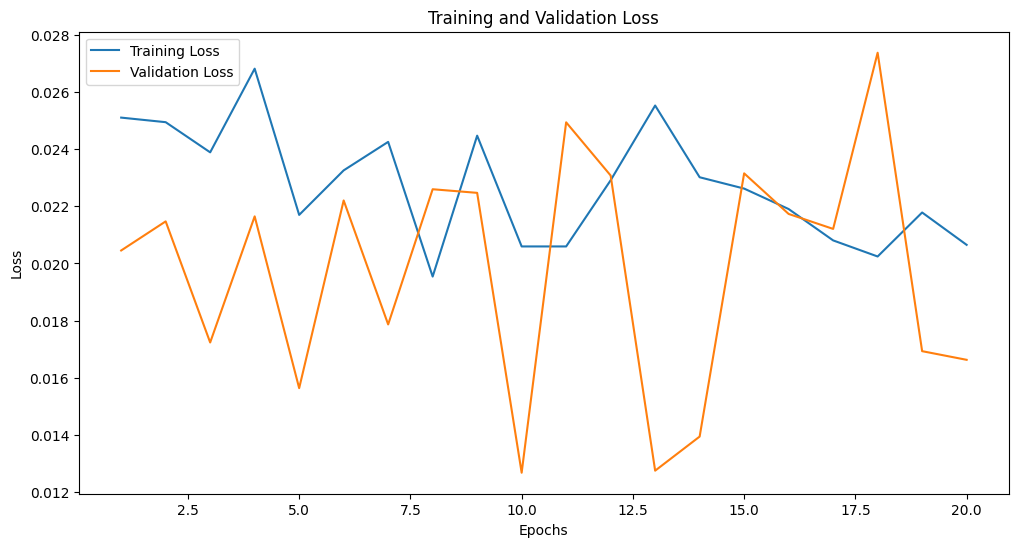

In [110]:
# extract train- and validation-loss
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

# plot history
plt.figure(figsize=(12, 6))
plt.plot(range(1, nb_epochs + 1), train_loss, label='Training Loss')
plt.plot(range(1, nb_epochs + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Test registration

In [111]:
# define validation generator
test_generator = vxm_data_generator(fixed_test, moved_test, batch_size = 1)
test_input, _ = next(test_generator)

In [112]:
# perform prediction
test_pred = vxm_model.predict(test_input)

1/1 [==============================] - 0s 500ms/step


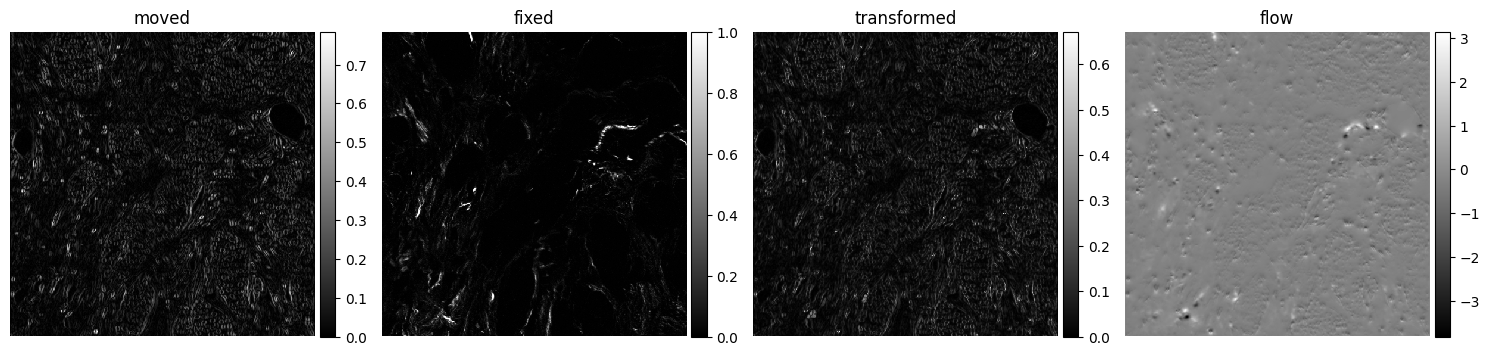

In [113]:
# view result
images = [img[0, :, :, 0] for img in test_input + test_pred]
titles = ['moved', 'fixed', 'transformed', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

(-0.5, 511.5, 511.5, -0.5)

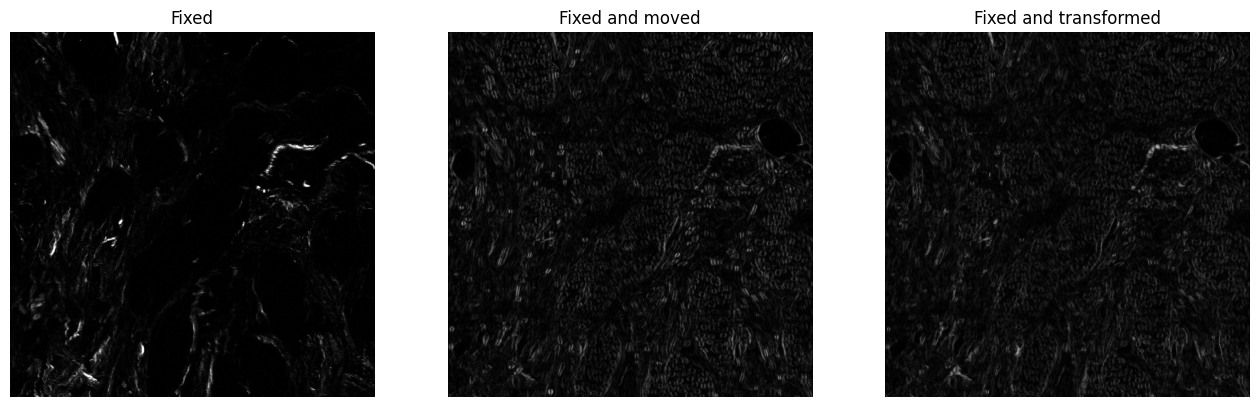

In [114]:
# view preprocessed data
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16,8))
ax0.imshow(test_input[1][0],cmap='gray')
ax0.set_title("Fixed")
ax0.axis("off")
ax1.imshow(test_input[1][0],cmap='gray')
ax1.imshow(test_input[0][0],cmap='gray', alpha=0.7)
ax1.set_title("Fixed and moved")
ax1.axis("off")
ax2.imshow(test_input[1][0],cmap='gray')
ax2.imshow(test_pred[0][0],cmap='gray', alpha=0.7)
ax2.set_title("Fixed and transformed")
ax2.axis("off")